# To run if on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

In [2]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!pip install umap-learn
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import requests
from bs4 import BeautifulSoup

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

import torch
import swifter
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Split the documents into tokens.
from nltk.tokenize import RegexpTokenizer

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Topic Distribution
from yellowbrick.text import UMAPVisualizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
# cleaning different patterns
def clean_tokens(tokens):
    tokens = re.sub(r'[^\w\s]', '', tokens)
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens)
    tokens = re.sub(r"http\S+", "", tokens) #removing HTTPS
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    
    return tokens.strip().lower()

In [5]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [6]:
# to interpret the postag to wordnet lexicon

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Loading the Training Set

In [7]:
df = pd.read_csv("gr_training_set.csv")

In [8]:
df.tail()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0,Romance
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1,NaN
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0,Young Adult
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0,Mystery
899999,b9450d1c1f97f891c392b1105959b56e,17005,d55f3a967230940e75a314700caec9a5,3,** spoiler alert ** \n 3.5 stars \n I liked it...,Sun Nov 11 00:05:43 -0800 2012,Sun Nov 11 21:59:08 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,0,0,Young Adult


# Checking Users' behaviour
If some users reviewed too many books and if the users reviewed the same books more than once

In [9]:
dist_user_reviews = sorted(list(df.user_id.value_counts().items()),
                           key = lambda x: -x[1]) #sorting on count

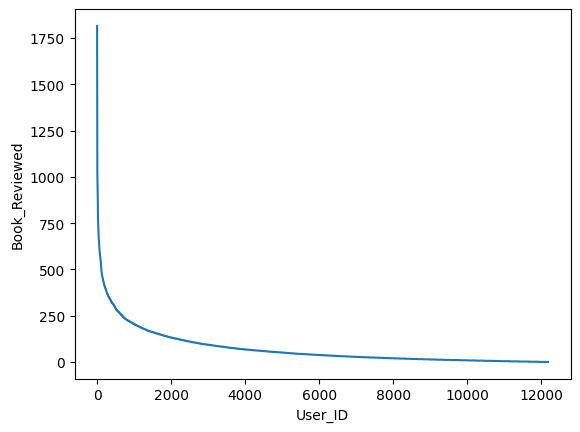

In [10]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

# conclusion: power law of a few users with lots of reviews
plt.plot([x[1] for x in dist_user_reviews])
plt.ylabel('Book_Reviewed')
plt.xlabel('User_ID')
plt.show()

In [11]:
book_per_user = df.groupby(['user_id', 'book_id']).count()['review_id']
book_per_user

user_id                           book_id 
000a1016fda6008d1edbba720ca00851  178476      1
                                  215643      1
                                  458034      1
                                  3863861     1
                                  6040871     1
                                             ..
ffff7cafdaf5196383cb2efca08fb6fe  27161826    1
                                  27272506    1
                                  28260587    1
                                  28954189    1
                                  32571395    1
Name: review_id, Length: 900000, dtype: int64

In [12]:
# no review of the same book
book_per_user.max()

1

# Balancing reviews per book
Sampling reviews pertaining to books with too many reviews

In [13]:
df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)

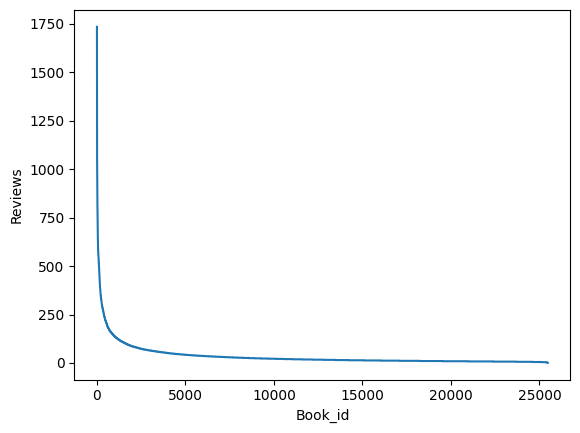

In [14]:
# too many reviews for some books, they need some balancing
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in df[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]
                                       
plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

In [15]:
#average number of reviews per book
average_rev = int(sum(reviews_x_book) / len(reviews_x_book) // 1)
average_rev

35

In [16]:
indexes_to_keep = df[df['n_review_per_book'] <= average_rev].index
index_sampled = df[df['n_review_per_book'] > average_rev].groupby('book_id').sample(average_rev).index

new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

In [17]:
df = df.loc[new_indexes].reset_index(drop=True)
len(df)

501745

# Dropping NaN genres

In [18]:
#Dropping NaN values
print(f"NaN values: {df.genre.isna().sum()}")
df.dropna(subset=['genre'], inplace=True)
print(f"NaN values: {df.genre.isna().sum()}")

NaN values: 71220
NaN values: 0


In [19]:
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 430525


# Storing the new training set

In [20]:
rev_df = df[["review_text","genre", "rating", "book_id"]]
#del df

In [21]:
rev_df.head()

,review_text,genre,rating,book_id
0,This is a special book. It started slow for ab...,Science Fiction,5,18245960
1,Recommended by Don Katz. Avail for free in Dec...,Classics,3,16981
2,"A fun, fast paced science fiction thriller. I ...",Science Fiction,3,28684704
3,"I really enjoyed this book, and there is a lot...",Science Fiction,4,25884323
7,A beautiful story. Neil Gaiman is truly a uniq...,Fantasy,5,5577844


In [22]:
len(rev_df)

430525

# Balancing the genres

In [23]:
list(enumerate(rev_df.genre.value_counts().items()))[:10]

[(0, ('Romance', 110224)),
 (1, ('Fantasy', 99576)),
 (2, ('Young Adult', 63176)),
 (3, ('Fiction', 28783)),
 (4, ('Science Fiction', 19808)),
 (5, ('Mystery', 17766)),
 (6, ('Sequential Art', 17078)),
 (7, ('Historical', 12771)),
 (8, ('Horror', 9878)),
 (9, ('Classics', 7518))]

In [24]:
# made it slightly more readable
genres_corresp = ((("Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fantasy")),
                  (("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism"), #-->
                   ("Fiction")),
                  (("Sequential Art", "Music", "Couture"), #-->
                   ("Art")),
                  (("Thriller", "Mystery", "Crime"), #-->
                   ("Thriller")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Horror")),
                  (("Classics", "Contemporary", "Poetry", "Plays"), #-->
                   ("Literature")),
                  (("Nonfiction", "Autobiography", "Biography"), #-->
                   ("NonFiction")),
                  (("Historical", "History", "War", "Mythology"), #-->
                   ("History")))

In [25]:
genres_to_keep_dict = {k : v for ks, v in genres_corresp for k in ks}
genres_to_keep_dict

{'Fantasy': 'Fantasy',
 'Superheroes': 'Fantasy',
 'Shapeshifters': 'Fantasy',
 'Science Fiction Fantasy': 'Fantasy',
 'Romance': 'Romance',
 'Erotica': 'Romance',
 'Polyamorous': 'Romance',
 'Category Romance': 'Romance',
 'Fiction': 'Fiction',
 'Young Adult': 'Fiction',
 'New Adult': 'Fiction',
 'Womens Fiction': 'Fiction',
 'Adult Fiction': 'Fiction',
 'Christian Fiction': 'Fiction',
 'Realistic Fiction': 'Fiction',
 'Fan Fiction': 'Fiction',
 'Magical Realism': 'Fiction',
 'Sequential Art': 'Art',
 'Music': 'Art',
 'Couture': 'Art',
 'Thriller': 'Thriller',
 'Mystery': 'Thriller',
 'Crime': 'Thriller',
 'Science Fiction': 'Science Fiction',
 'Horror': 'Horror',
 'Paranormal': 'Horror',
 'Dark': 'Horror',
 'Suspense': 'Horror',
 'Classics': 'Literature',
 'Contemporary': 'Literature',
 'Poetry': 'Literature',
 'Plays': 'Literature',
 'Nonfiction': 'NonFiction',
 'Autobiography': 'NonFiction',
 'Biography': 'NonFiction',
 'Historical': 'History',
 'History': 'History',
 'War': 'Histo

In [26]:
print(f"Initial rows: {len(rev_df)}")
rev_df = rev_df[rev_df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
print(f"Filtered len: {len(rev_df)}")

Initial rows: 430525
Filtered len: 420214


In [27]:
rev_df.genre = rev_df.genre.map(lambda genere: genres_to_keep_dict[genere])
rev_df.head()

,review_text,genre,rating,book_id
0,This is a special book. It started slow for ab...,Science Fiction,5,18245960
1,Recommended by Don Katz. Avail for free in Dec...,Literature,3,16981
2,"A fun, fast paced science fiction thriller. I ...",Science Fiction,3,28684704
3,"I really enjoyed this book, and there is a lot...",Science Fiction,4,25884323
4,A beautiful story. Neil Gaiman is truly a uniq...,Fantasy,5,5577844


In [28]:
rev_df.genre.value_counts()

Romance            113261
Fiction            102767
Fantasy             99660
Thriller            21056
Science Fiction     19808
Horror              18046
Art                 17111
History             13436
Literature           9729
NonFiction           5340
Name: genre, dtype: int64

# Class Undersampling

In [29]:
n = 2000
genres_w_more_than_n_reviews = rev_df.groupby('genre')['genre'].transform(len) >= n
rev_df_reduced = pd.concat((rev_df[genres_w_more_than_n_reviews].groupby('genre').sample(n=n), 
                            rev_df[~genres_w_more_than_n_reviews]), ignore_index=True)

In [30]:
rev_df_reduced.genre.value_counts()

Art                2000
Fantasy            2000
Fiction            2000
History            2000
Horror             2000
Literature         2000
NonFiction         2000
Romance            2000
Science Fiction    2000
Thriller           2000
Name: genre, dtype: int64

# Plotting Genres distribution

In [31]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

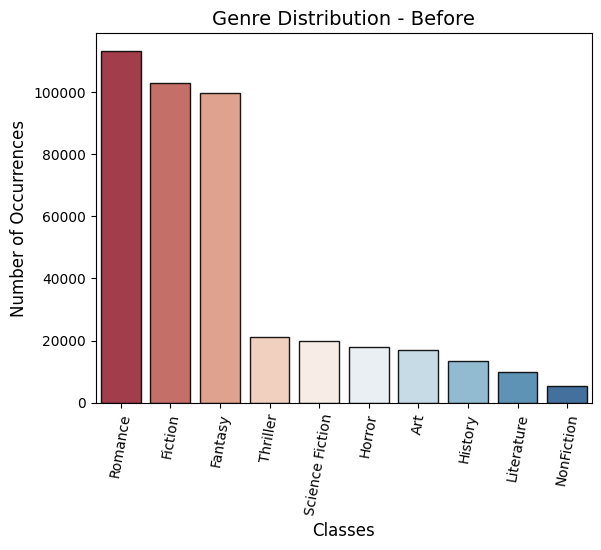

In [32]:
sns.barplot([x for x in rev_df.genre.value_counts().index],
            [y for y in rev_df.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - Before',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

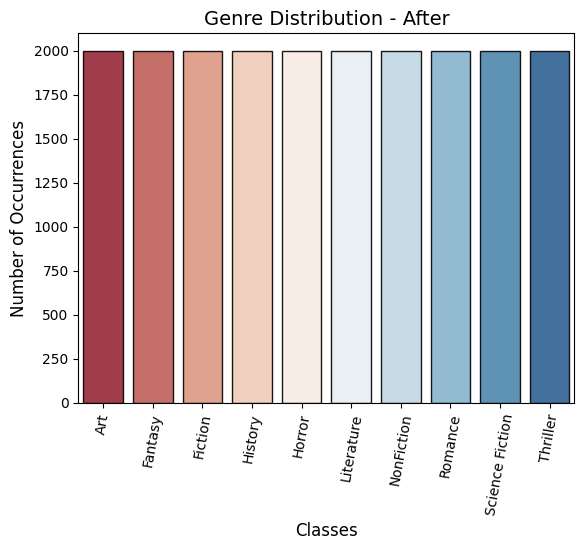

In [33]:
sns.barplot([x for x in rev_df_reduced.genre.value_counts().index],
            [y for y in rev_df_reduced.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - After',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

In [34]:
#cleaning review_text col
rev_df = rev_df_reduced
rev_df.review_text = rev_df.review_text.swifter.apply(lambda x: clean_tokens(x))
rev_df.head()

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id
0,another solid entry in the series were definit...,Art,3,26218626
1,i won this book from goodreads which is cool ...,Art,5,16002008
2,actual rating so cute i have ordered the nex...,Art,3,10862575
3,no review,Art,5,6327801
4,the artwork is amazing but the gratuous female...,Art,3,25732455


# Tokeninzing the Text

In [35]:
rev_df["tokenized_text"] = rev_df.review_text.swifter.apply(lambda x: word_tokenize(x))
rev_df.head()

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id,tokenized_text
0,another solid entry in the series were definit...,Art,3,26218626,"[another, solid, entry, in, the, series, were,..."
1,i won this book from goodreads which is cool ...,Art,5,16002008,"[i, won, this, book, from, goodreads, which, i..."
2,actual rating so cute i have ordered the nex...,Art,3,10862575,"[actual, rating, so, cute, i, have, ordered, t..."
3,no review,Art,5,6327801,"[no, review]"
4,the artwork is amazing but the gratuous female...,Art,3,25732455,"[the, artwork, is, amazing, but, the, gratuous..."


# POS tagging

The Part Of Speech tag. Valid options are `"n"` for nouns, `"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"` for satellite adjectives.

In [36]:
rev_df["postagged_text"] = rev_df.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [37]:
list_of_tags = rev_df.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [38]:
pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}

In [39]:
list(pos_mapper.items())[:5]

[('NNPS', 'n'), ('JJR', 'a'), ('JJ', 'a'), ('WDT', None), ('WP', None)]

In [40]:
#import spacy

# Load English tokenizer, tagger, parser and NER
#nlp = spacy.load("en_core_web_sm")

In [41]:
#doc = nlp(" ".join(rev_df.tokenized_text[1]))
#print(doc[:100])

# Removing Stop Words

In [42]:
print(f"e.g. a token list len before: {len(rev_df.tokenized_text[0])}")
rev_df["tokenized_text"] = remove_stop_words(rev_df["tokenized_text"], pos = False)
print(f"e.g. a token list len after: {len(rev_df.tokenized_text[0])}")

e.g. a token list len before: 13
e.g. a token list len after: 6


In [43]:
print(f"e.g. a token list len before: {len(rev_df.postagged_text[0])}")
rev_df["postagged_text"] = remove_stop_words(rev_df["postagged_text"], pos = True)
print(f"e.g. a token list len after: {len(rev_df.postagged_text[0])}")

e.g. a token list len before: 13
e.g. a token list len after: 6


# Filtering out short words

In [44]:
rev_df.head()

,review_text,genre,rating,book_id,tokenized_text,postagged_text
0,another solid entry in the series were definit...,Art,3,26218626,"[solid, entry, series, definitely, home, stretch]","[(solid, JJ), (entry, NN), (series, NN), (defi..."
1,i won this book from goodreads which is cool ...,Art,5,16002008,"[won, book, goodreads, cool, cute, story, embr...","[(won, VBD), (book, NN), (goodreads, NNS), (co..."
2,actual rating so cute i have ordered the nex...,Art,3,10862575,"[actual, rating, cute, ordered, volume]","[(actual, JJ), (rating, NN), (cute, JJ), (orde..."
3,no review,Art,5,6327801,[review],"[(review, NN)]"
4,the artwork is amazing but the gratuous female...,Art,3,25732455,"[artwork, amazing, gratuous, female, nudity, s...","[(artwork, NN), (amazing, VBG), (gratuous, JJ)..."


In [45]:
# minimum length of the remaining words of the fixed tokenized text 
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

1

In [46]:
#filtering the words with a length less than 4
rev_df["tokenized_text"] = rev_df.tokenized_text.map(lambda x: [el for el in x if len(el) > 3])
rev_df["postagged_text"] = rev_df.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 3])

In [47]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.tokenized_text.map(lambda x: ([len(el) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

4

In [48]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

4

# Lemmatize the Tokens

In [101]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos_mapper[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [102]:
#lemmatizing
rev_df['lemmatized_text'] = rev_df.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [103]:
rev_df.head()

,review_text,genre,rating,book_id,tokenized_text,postagged_text,lemmatized_text
0,another solid entry in the series were definit...,Art,3,26218626,"[solid, entry, series, definitely, home, stretch]","[(solid, JJ), (entry, NN), (series, NN), (defi...","[solid, entry, series, definitely, home, stretch]"
1,i won this book from goodreads which is cool ...,Art,5,16002008,"[book, goodreads, cool, cute, story, embracing...","[(book, NN), (goodreads, NNS), (cool, JJ), (cu...","[book, goodreads, cool, cute, story, embrace, ..."
2,actual rating so cute i have ordered the nex...,Art,3,10862575,"[actual, rating, cute, ordered, volume]","[(actual, JJ), (rating, NN), (cute, JJ), (orde...","[actual, rating, cute, order, volume]"
3,no review,Art,5,6327801,[review],"[(review, NN)]",[review]
4,the artwork is amazing but the gratuous female...,Art,3,25732455,"[artwork, amazing, gratuous, female, nudity, s...","[(artwork, NN), (amazing, VBG), (gratuous, JJ)...","[artwork, amaze, gratuous, female, nudity, sto..."


# Extracting Vocabulary 

In [104]:
dict_count = dict(sorted(nltk.FreqDist([word for text in rev_df["lemmatized_text"] for word in text]).items(), 
                         key=lambda x: x[1], reverse=True))

In [105]:
list(dict_count.items())[:6]

[('book', 39017),
 ('read', 21050),
 ('like', 19037),
 ('story', 17034),
 ('love', 14766),
 ('character', 13748)]

In [106]:
# getting the max frequency of a word that appear in at most 99% of the review corpus 
maximum_threshold = np.quantile(list(dict_count.values()), 0.99)

In [107]:
# filtering out the extremes of the distribution
dict_count_fixed = {k:v for k,v in dict_count.items() if v > 5 and v < maximum_threshold}
# dict_count_fixed

In [108]:
vocabulary = set(dict_count_fixed.keys())
# vocabulary
len(vocabulary)

13685

# Topic Distribution

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

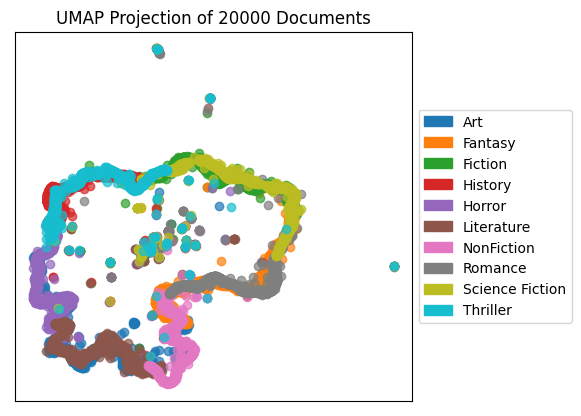

<Figure size 2000x1200 with 0 Axes>

In [110]:
tfidf = TfidfVectorizer()
umap = UMAPVisualizer()

corpus = rev_df["lemmatized_text"].swifter.apply(lambda x: ' '.join(x))
labels = rev_df['genre']

docs = tfidf.fit_transform(corpus)
umap.fit(docs, labels)

plt.figure(figsize=(20, 12))
umap.show()

In [ ]:
# for later
# from yellowbrick.text.tsne import tsne

# Sentiment Analysis on Sample

In [ ]:
rev_df['super_lemma'] = rev_df["lemmatized_text"].swifter.apply(lambda x: ' '.join(x))
adjust_me_later = 'super_lemma'

In [49]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [50]:
sample_sentiment = rev_df[adjust_me_later].sample(500, random_state = 42)
index_sample = sample_sentiment.index

In [51]:
start = time.time()
sentiment_score(sample_sentiment.loc[index_sample[0]])
end = time.time()
print(end-start)

0.3170773983001709


In [52]:
sentiment_result = sample_sentiment.swifter.apply(lambda x: sentiment_score(x[:512]))

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [53]:
sentiment_df = pd.concat((rev_df['review_text'].loc[index_sample], sentiment_result), axis= 1).rename(columns={adjust_me_later:"sentiment"}).reset_index(drop=True)

In [54]:
sentiment_df.head()

,review_text,sentiment
0,haunting and memorable also i want to urge pe...,5
1,i gave it stars chloe neills chicagoland vam...,3
2,actual rating is stars i did enjoy the exper...,3
3,the first page of issue involves a sassy sher...,1
4,posthumously published biography of neurosurge...,1


In [55]:
sentiment_df.loc[sentiment_df.index[0]]['review_text'], sentiment_df.loc[sentiment_df.index[0]]['sentiment']

('haunting and memorable  also i want to urge people to stop romanticizing this story',
 5)

In [56]:
sentiment_df.loc[sentiment_df.index[1]]['review_text'], sentiment_df.loc[sentiment_df.index[1]]['sentiment']

('i gave it  stars  chloe neills chicagoland vampires novels have a prominent place on my bookshelf so when i saw that she had a new series coming out i knew i would be reading it as soon as i could get my hands on it  the setting was a big plus for me i have never been to new orleans but have read a lot about it and i found chloes version of new orleans to be very interesting and easy to follow i enjoyed the postapocalypticdystopian feel as well as the whole devils isle aspect of the city the fae storyline was interesting and i found myself looking forward to more details as i was reading  for some reason i wasnt overly invested in the main characters and actually connected to a few of the secondary characters quicker which is a bit weird to me thats not to say i didnt like the main characters i did i just would have liked to feel more invested in them by the end of the book there was some romance between claire and liam which i actually enjoyed quite a bit liam held himself back a lo

# Entities

In [ ]:
for entity in doc.ents:
    print(entity.text, entity.label_)

In [ ]:
doc.ents

In [ ]:
from spacy import displacy

displacy.render(doc, style="ent")

# WorldCloud

In [ ]:
def plot_cloud_rating(df, rating):
    review = rev_df[rev_df.rating == rating]["review_text"]
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(review.values[0])
    plt.figure(figsize=(15,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
review = rev_df[rev_df.rating == 1]["review_text"]
review[:5]

In [ ]:
plot_cloud_rating(rev_df, 5)

In [ ]:
def frequency_per_genre(df, genre):
    df_review = df[df.genre == genre]
    
    tokenized_text = word_tokenize(" ".join([el for el in df_review["review_text"]]))
    
    frequency_distribution = dict(sorted(nltk.FreqDist(
    [parola for parola in tokenized_text if parola not in stop_words and parola.isalpha()]).items(), 
                                     key=lambda x:x[1], 
                                     reverse= True))
    return frequency_distribution
    
def plot_cloud_genre(df, genre = None, freq_dist_new = None):
    if not freq_dist_new:
        freq_dist_new = frequency_per_genre(df, genre)
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq_dist_new)
    plt.figure(figsize=(15,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
plot_cloud_genre(rev_df, "Science Fiction")

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_text(" ".join([parola for lista in rev_df[rev_df.genre == "Science Fiction"]["tokenized_text"] for parola in lista]))
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_text(" ".join([el for el in rev_df[rev_df.genre == "Romance"]["review_text"]]))
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()